# Post processing of mumax3 output data in python

intr intro

## Getting ready

If you want to run the examples in this notebook, then mumax3 must be is installed on the system that is running this notebook. Go to [mumax.github.io/download](http://mumax.github.io/download) for more information on how to install mumax3 on your system. If you are running this notebook in a google collaboratory session, it suffices to run the cell below to install mumax3 and update the PATH environment variable. 

In [56]:
try:
    import google.colab
except ImportError:
    pass
else:
    !wget https://mumax.ugent.be/mumax3-binaries/mumax3.10_linux_cuda10.1.tar.gz
    !tar -xvf mumax3.10_linux_cuda10.1.tar.gz
    !rm mumax3.10_linux_cuda10.1.tar.gz
    !rm -rf mumax3.10 && mv mumax3.10_linux_cuda10.1 mumax3.10
    import os
    os.environ['PATH'] += ":/content/mumax3.10"

In the examples presented in this notebook, we will use the numpy and pandas libraries for post processing mumax3 output data, and matplotlib to visualize this data. So let's import these libraries.

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## mumax3 helper functions

Let's start by writing a function which reads a mumax3 output table and puts it in a Pandas dataframe.

In [58]:
def read_mumax3_table(filename):
    """Puts the mumax3 output table in a pandas dataframe"""

    from pandas import read_table
    
    table = read_table(filename)
    table.columns = ' '.join(table.columns).split()[1::2]
    
    return table

Mumax3 does not only write output data in a table, it can also write data to ovf fields. The function below converts all ovf files in the output directory to numpy files. These files are then loaded using the numpy.load function. 

In [17]:
def read_mumax3_ovffiles(outputdir):
    """Load all ovffiles in outputdir into a dictionary of numpy arrays 
    with the ovffilename (without extension) as key"""
    
    from subprocess import run, PIPE, STDOUT
    from glob import glob
    from os import path
    from numpy import load

    # convert all ovf files in the output directory to numpy files
    p = run(["mumax3-convert","-numpy",outputdir+"/*.ovf"], stdout=PIPE, stderr=STDOUT)
    if p.returncode != 0:
        print(p.stdout.decode('UTF-8'))

    # read the numpy files (the converted ovf files)
    fields = {}
    for npyfile in glob(outputdir+"/*.npy"):
        key = path.splitext(path.basename(npyfile))[0]
        fields[key] = load(npyfile)
    
    return fields

The function below executes a mumax3 script and returns the data of the output table in a pandas dataframe, and the saved fields as numpy arrays.

In [81]:
def run_mumax3(script, name, verbose=False):
    """ Executes a mumax3 script and convert ovf files to numpy files
    
    Parameters
    ----------
      script:  string containing the mumax3 input script
      name:    name of the simulation (used to name the script and output dir)
      verbose: print stdout of mumax3 when it is finished
    """
    
    from subprocess import run, PIPE, STDOUT
    from os import path

    scriptfile = name + ".txt" 
    outputdir  = name + ".out"

    # write the input script in scriptfile
    with open(scriptfile, 'w' ) as f:
        f.write(script)
    
    # call mumax3 to execute this script
    p = run(["mumax3","-f",scriptfile], stdout=PIPE, stderr=STDOUT)
    if verbose or p.returncode != 0:
        print(p.stdout.decode('UTF-8'))
        
    if path.exists(outputdir + "/table.txt"):
        table = read_mumax3_table(outputdir + "/table.txt")
    else:
        table = None
        
    fields = read_mumax3_ovffiles(outputdir)
    
    return table, fields

## Standard problem 4 revisited

Let's start by putting the mumax3 input script for standard problem 4 in the string variable `script`.

In [65]:
script="""
SetGridsize(128, 32, 1)
SetCellsize(500e-9/128, 125e-9/32, 3e-9)

Msat  = 800e3
Aex   = 13e-12
alpha = 0.02

m = uniform(1, .1, 0)
relax()

autosave(m, 200e-12)
tableadd(e_total)
tableautosave(10e-12)

B_ext = vector(-24.6E-3, 4.3E-3, 0)
run(1e-9)
"""

Now we can execute this mumax3 script using the `run_mumax3` helper function. This function returns the output table in a pandas dataframe and a dictionary of the saved fields. If `verbose=True`, then the log output of mumax3 will be printed out when mumax3 finishes. Note that on the left side of the cell, you can check if the simulation is finished or still running.

In [74]:
table, fields = run_mumax3( script, name="standardproblem4", verbose=False )

The table data is put in a pandas dataframe. This makes it very easy to plot and analyze the table data.

                t        mx        my        mz       E_total
0    0.000000e+00  0.966966  0.125280  0.000000  4.113433e-18
1    1.047995e-11  0.963904  0.135637 -0.013082  4.112652e-18
2    2.049311e-11  0.954859  0.163505 -0.024929  4.109999e-18
3    3.052655e-11  0.938358  0.207008 -0.035884  4.103970e-18
4    4.032157e-11  0.913384  0.261737 -0.045413  4.093901e-18
..            ...       ...       ...       ...           ...
96   9.602557e-10 -0.969346 -0.076203 -0.002650 -2.657132e-18
97   9.705168e-10 -0.975587 -0.060504  0.017528 -2.666431e-18
98   9.800958e-10 -0.983594 -0.016619  0.032775 -2.679360e-18
99   9.903616e-10 -0.988094  0.052699  0.042328 -2.698605e-18
100  1.000000e-09 -0.984612  0.126046  0.043269 -2.718244e-18

[101 rows x 5 columns]


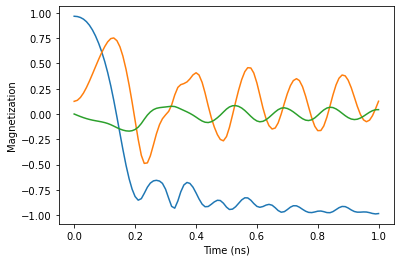

In [77]:
print(table)

plt.figure()

nanosecond = 1e-9
plt.plot( table["t"]/nanosecond, table["mx"])
plt.plot( table["t"]/nanosecond, table["my"])
plt.plot( table["t"]/nanosecond, table["mz"])

plt.xlabel("Time (ns)")
plt.ylabel("Magnetization")

plt.show()

['m000000', 'm000001', 'm000002', 'm000003', 'm000004', 'm000005']


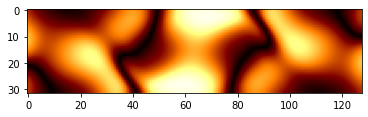

In [35]:
print(sorted(fields.keys()))

def show_abs_my(m):
    my_abs = np.abs( m[1,0,:,:] )
    plt.figure()
    plt.imshow(my_abs, vmin=0, vmax=1, cmap="afmhot")
    plt.show()

show_abs_my(fields["m000001"])

## Ferromagnetic spinwave dispersion relation

$$ 2 \pi f = \omega = 2\gamma\frac{A}{M_s} k^2 +\gamma B $$

In [82]:
# NUMERICAL PARAMETERS
fmax = 20e9        # maximum frequency (in Hz) of the sinc pulse
T    = 1e-8        # simulation time (longer -> better frequency resolution)
dt   = 1/(4*fmax)  # the sample time
dx   = 4e-9        # cellsize
nx   = 1024        # number of cells

# MATERIAL/SYSTEM PARAMETERS
Bz    = 0.2        # Bias field along the z direction
A     = 13e-12     # exchange constant
Ms    = 800e3      # saturation magnetization
alpha = 0.05       # damping parameter


script=f"""
setgridsize({nx},1,1)
setcellsize({dx},{dx},{dx})

enabledemag = false
Aex = {A}
Msat = {Ms}
alpha = {alpha}

Bz := {Bz}
B_ext = vector(0,0,{Bz})
defregion(1,rect(2*{dx},inf))
B_ext.setregion(1, vector(0.01 * sinc( 2*pi*{fmax}*(t-{T}/2)), 0, {Bz}))

m = uniform(0,0,1) 
autosave(m,{dt})
run({T})
"""
 
table, fields = run_mumax3(script,"spinwaves")

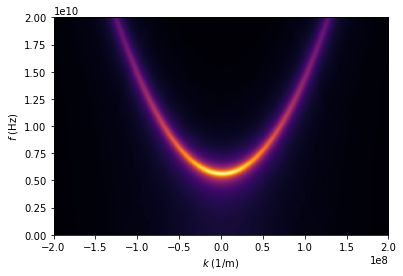

In [83]:
mx = np.stack([fields[key][0,0,0] for key in sorted(fields.keys())])

mx_fft = np.fft.fft2(mx)
mx_fft = np.fft.fftshift(mx_fft)

extent = [ -(2*np.pi) / (2*dx), (2*np.pi) / (2*dx), -1 / (2*dt), 1 / (2*dt)] 

gammaLL = 1.76e11
def dispersion(k):
    return A*gammaLL*k**2 /(np.pi*Ms) + gammaLL*Bz /(2*np.pi)

plt.figure()
plt.imshow(np.abs(mx_fft), extent=extent, aspect='auto', origin='lower', cmap="inferno")

#k = np.linspace(-2e8,2e8,1000)
#plt.plot(k,dispersion(k),'r--',lw=1)
#plt.axhline(gammaLL*Bz/(2*np.pi),c='g',ls='--',lw=1)

plt.xlim([-2e8,2e8])
plt.ylim([0,fmax])
plt.ylabel("$f$ (Hz)")
plt.xlabel("$k$ (1/m)")

plt.show()